

This notebook demonstrates how to build an unsupervised learning AI agent that performs:
1. Customer segmentation using K-Means clustering
2. Market basket analysis using association rule mining

### Learning Objectives:
- Apply unsupervised learning to solve real business problems
- Implement customer segmentation and discover purchasing patterns
- Create actionable business insights from data mining results

## Table of Contents
1. [Environment Setup and Library Installation](#setup)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing and Feature Engineering](#preprocessing)
4. [Customer Segmentation with K-Means Clustering](#segmentation)
5. [Market Basket Analysis with Apriori Algorithm](#market-basket)
6. [Business Insights and Recommendations](#insights)

## 1. Environment Setup and Library Installation <a id='setup'></a>

First, we'll install and import all necessary libraries for our analysis.

In [2]:
# Install required libraries (run this cell if using Google Colab)
!pip install pandas numpy matplotlib seaborn scikit-learn mlxtend plotly -q

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# For association rules
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("All libraries imported successfully!")

All libraries imported successfully!


### Key Terms Explained:

**Unsupervised Learning**: Machine learning techniques that find patterns in data without labeled outcomes. Unlike supervised learning (which predicts a specific target), unsupervised learning discovers hidden structures.

**Clustering**: Grouping similar data points together based on their characteristics. In business, this helps identify customer segments with similar behaviors.

**Association Rule Mining**: Finding relationships between items that frequently occur together, like "customers who buy bread often buy butter."

## 2. Data Loading and Exploration <a id='data-loading'></a>

We'll use the Online Retail dataset, which contains transactions from a UK-based online retailer.

In [4]:
# Load the Online Retail dataset
# This dataset is commonly used for customer analytics demonstrations
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# Load data
print("Loading data... This may take a moment.")
df = pd.read_excel(url)
print(f"Data loaded successfully! Shape: {df.shape}")

# Display basic information
print("\nDataset Overview:")
print(df.info())

Loading data... This may take a moment.
Data loaded successfully! Shape: (541909, 8)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [5]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Understand the columns
print("Column Descriptions:")
print("- InvoiceNo: Invoice number (unique per transaction)")
print("- StockCode: Product code")
print("- Description: Product name")
print("- Quantity: Number of items purchased")
print("- InvoiceDate: Date and time of transaction")
print("- UnitPrice: Price per unit")
print("- CustomerID: Unique customer identifier")
print("- Country: Customer's country")

# Basic statistics
print("\nBasic Statistics:")
print(f"Total transactions: {len(df)}")
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique products: {df['StockCode'].nunique()}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Column Descriptions:
- InvoiceNo: Invoice number (unique per transaction)
- StockCode: Product code
- Description: Product name
- Quantity: Number of items purchased
- InvoiceDate: Date and time of transaction
- UnitPrice: Price per unit
- CustomerID: Unique customer identifier
- Country: Customer's country

Basic Statistics:
Total transactions: 541909
Unique customers: 4372
Unique products: 4070
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


## 3. Data Preprocessing and Feature Engineering <a id='preprocessing'></a>

### Data Cleaning
We need to clean the data before analysis:
1. Remove missing CustomerIDs (can't segment unknown customers)
2. Remove negative quantities (returns/cancellations)
3. Calculate total price for each line item

In [7]:
# Data cleaning
print(f"Original data shape: {df.shape}")

# Remove rows with missing CustomerID
df_clean = df.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerIDs: {df_clean.shape}")

# Remove negative quantities (returns)
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"After removing returns: {df_clean.shape}")

# Remove zero or negative prices
df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"After removing invalid prices: {df_clean.shape}")

# Calculate total price for each line item
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Convert CustomerID to integer
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

print(f"\nFinal cleaned data shape: {df_clean.shape}")
print(f"Data retention rate: {len(df_clean)/len(df)*100:.1f}%")

Original data shape: (541909, 8)
After removing missing CustomerIDs: (406829, 8)
After removing returns: (397924, 8)
After removing invalid prices: (397884, 8)

Final cleaned data shape: (397884, 9)
Data retention rate: 73.4%


### RFM Analysis

**RFM** stands for:
- **Recency**: How recently did the customer make a purchase?
- **Frequency**: How often do they make purchases?
- **Monetary**: How much do they spend?

RFM analysis is a fundamental technique in customer analytics that helps identify valuable customers.

In [8]:
# Calculate RFM metrics
# Define the reference date (latest date in dataset + 1 day)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date}")

# Create RFM table
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (number of unique invoices)
    'TotalPrice': 'sum'  # Monetary value
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Reset index
rfm = rfm.reset_index()

print("\nRFM Table Summary:")
print(rfm.describe())

# Display sample RFM data
print("\nSample RFM data:")
rfm.head(10)

Reference date for recency calculation: 2011-12-10 12:50:00

RFM Table Summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

Sample RFM data:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2506.04
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2811.43


In [9]:
# Add additional customer features
# Average order value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Number of unique products purchased
products_per_customer = df_clean.groupby('CustomerID')['StockCode'].nunique().reset_index()
products_per_customer.columns = ['CustomerID', 'UniqueProducts']
rfm = rfm.merge(products_per_customer, on='CustomerID')

# Product diversity (unique products / total transactions)
transactions_per_customer = df_clean.groupby('CustomerID').size().reset_index(name='TotalTransactions')
rfm = rfm.merge(transactions_per_customer, on='CustomerID')
rfm['ProductDiversity'] = rfm['UniqueProducts'] / rfm['TotalTransactions']

print("\nEnhanced customer features:")
print(rfm.columns.tolist())
print("\nSample enhanced data:")
rfm.head()


Enhanced customer features:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'UniqueProducts', 'TotalTransactions', 'ProductDiversity']

Sample enhanced data:


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,UniqueProducts,TotalTransactions,ProductDiversity
0,12346,326,1,77183.60,77183.600000,1,1,1.000000
1,12347,2,7,4310.00,615.714286,103,182,0.565934
2,12348,75,4,1797.24,449.310000,22,31,0.709677
3,12349,19,1,1757.55,1757.550000,73,73,1.000000
4,12350,310,1,334.40,334.400000,17,17,1.000000


### Visualize RFM Distributions

Understanding the distribution of our features helps identify outliers and patterns.

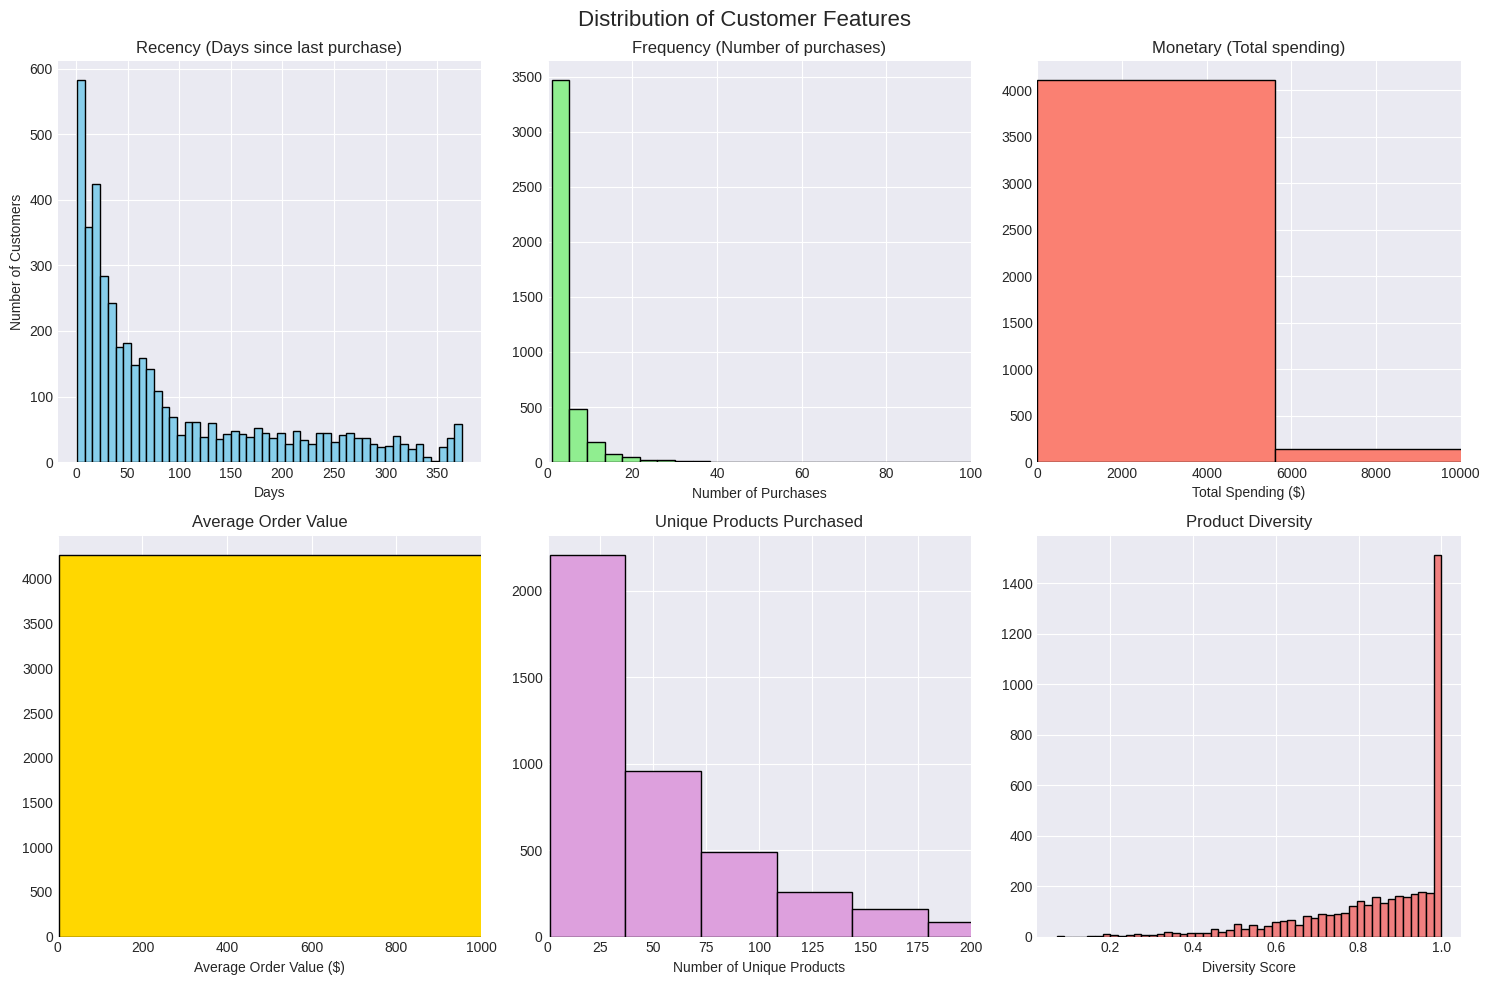

In [10]:
# Create visualizations for RFM metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Customer Features', fontsize=16)

# Recency
axes[0, 0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency (Days since last purchase)')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Number of Customers')

# Frequency
axes[0, 1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency (Number of purchases)')
axes[0, 1].set_xlabel('Number of Purchases')
axes[0, 1].set_xlim(0, 100)  # Limit x-axis for better visibility

# Monetary
axes[0, 2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[0, 2].set_title('Monetary (Total spending)')
axes[0, 2].set_xlabel('Total Spending ($)')
axes[0, 2].set_xlim(0, 10000)  # Limit x-axis for better visibility

# Average Order Value
axes[1, 0].hist(rfm['AvgOrderValue'], bins=50, color='gold', edgecolor='black')
axes[1, 0].set_title('Average Order Value')
axes[1, 0].set_xlabel('Average Order Value ($)')
axes[1, 0].set_xlim(0, 1000)

# Unique Products
axes[1, 1].hist(rfm['UniqueProducts'], bins=50, color='plum', edgecolor='black')
axes[1, 1].set_title('Unique Products Purchased')
axes[1, 1].set_xlabel('Number of Unique Products')
axes[1, 1].set_xlim(0, 200)

# Product Diversity
axes[1, 2].hist(rfm['ProductDiversity'], bins=50, color='lightcoral', edgecolor='black')
axes[1, 2].set_title('Product Diversity')
axes[1, 2].set_xlabel('Diversity Score')

plt.tight_layout()
plt.show()

## 4. Customer Segmentation with K-Means Clustering <a id='segmentation'></a>

### Feature Scaling

**Feature scaling** is crucial for clustering algorithms because they calculate distances between points. Without scaling, features with larger values (like Monetary) would dominate over features with smaller values (like Frequency).

In [11]:
# Select features for clustering
clustering_features = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'UniqueProducts']
X = rfm[clustering_features]

# Handle outliers using IQR method
# Outliers can significantly affect clustering results
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
print("Removing outliers...")
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[mask]
rfm_clean = rfm[mask]

print(f"Original data: {len(X)} customers")
print(f"After outlier removal: {len(X_clean)} customers")
print(f"Outliers removed: {len(X) - len(X_clean)} ({(len(X) - len(X_clean))/len(X)*100:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("\nFeatures have been scaled to have mean=0 and std=1")

Removing outliers...
Original data: 4338 customers
After outlier removal: 3444 customers
Outliers removed: 894 (20.6%)

Features have been scaled to have mean=0 and std=1


### Finding Optimal Number of Clusters

**Elbow Method**: Plots the within-cluster sum of squares (WCSS) against the number of clusters. The "elbow" point where the rate of decrease sharply levels off suggests the optimal number of clusters.

**Silhouette Score**: Measures how similar each point is to its own cluster compared to other clusters. Ranges from -1 to 1, where higher is better.

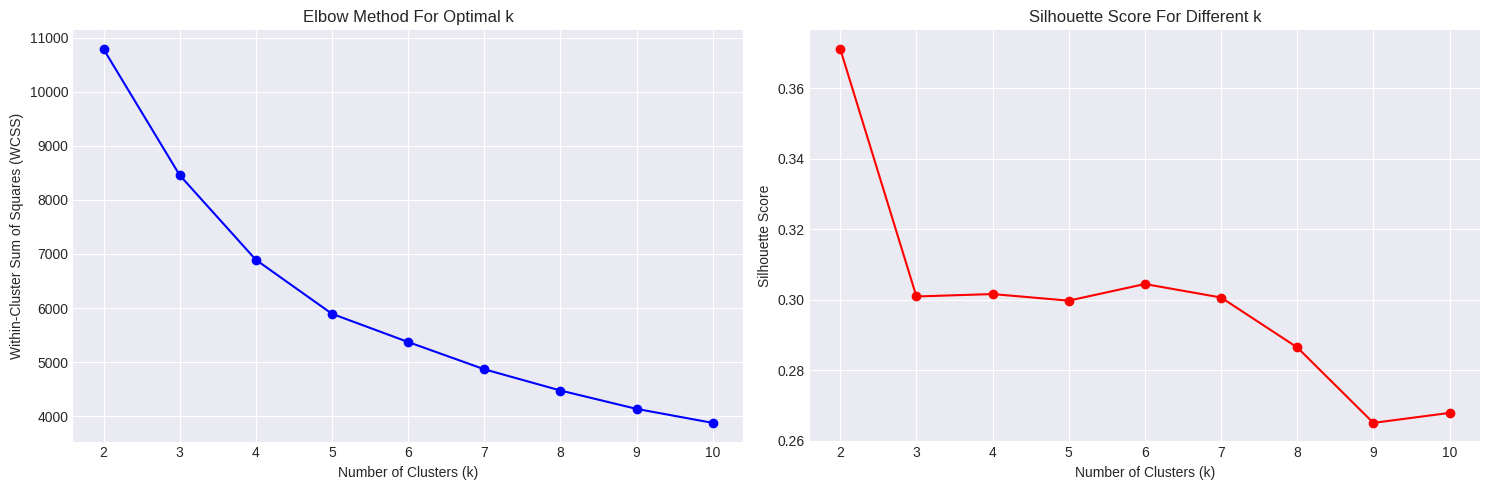


Optimal number of clusters based on Silhouette Score: 2
Silhouette Score for k=2: 0.371


In [12]:
# Elbow method to find optimal k
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(K, wcss, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method For Optimal k')
ax1.grid(True)

# Silhouette scores
ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score For Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = K[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"Silhouette Score for k={optimal_k}: {max(silhouette_scores):.3f}")

### Apply K-Means Clustering

In [13]:
# Apply K-Means with optimal k
optimal_k = 4  # You can adjust based on the plots above
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
rfm_clean['Cluster'] = clusters

# Calculate cluster centers in original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=clustering_features)
cluster_centers_df['Cluster'] = range(optimal_k)

print("Cluster Centers (Original Scale):")
print(cluster_centers_df.round(2))

# Cluster sizes
print("\nCluster Sizes:")
cluster_sizes = rfm_clean['Cluster'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} customers ({size/len(rfm_clean)*100:.1f}%)")

Cluster Centers (Original Scale):
   Recency  Frequency  Monetary  AvgOrderValue  UniqueProducts  Cluster
0    75.97       2.03    951.14         488.86           45.95        0
1    35.61       6.07   1959.69         339.21           91.52        1
2    46.34       2.28    437.49         198.08           28.62        2
3   230.31       1.44    303.62         221.43           18.73        3

Cluster Sizes:
Cluster 0: 670 customers (19.5%)
Cluster 1: 669 customers (19.4%)
Cluster 2: 1333 customers (38.7%)
Cluster 3: 772 customers (22.4%)


### Visualize Clusters

We'll use **PCA (Principal Component Analysis)** to reduce our multi-dimensional data to 2D for visualization. PCA finds the directions of maximum variance in the data.

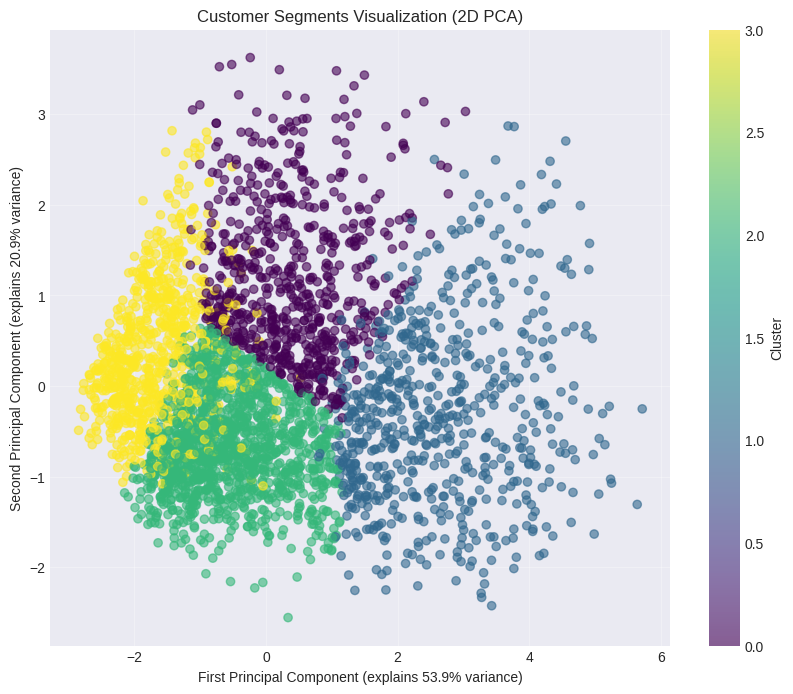

Total variance explained by 2 components: 74.8%


In [14]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Segments Visualization (2D PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.1%}")

### Analyze Cluster Characteristics

Average Values by Cluster:
         Recency  Frequency  Monetary  AvgOrderValue  UniqueProducts
Cluster                                                             
0          76.06       2.02    951.11         489.11           45.94
1          35.61       6.07   1959.69         339.21           91.52
2          46.31       2.28    437.89         198.18           28.64
3         230.31       1.44    303.62         221.43           18.73


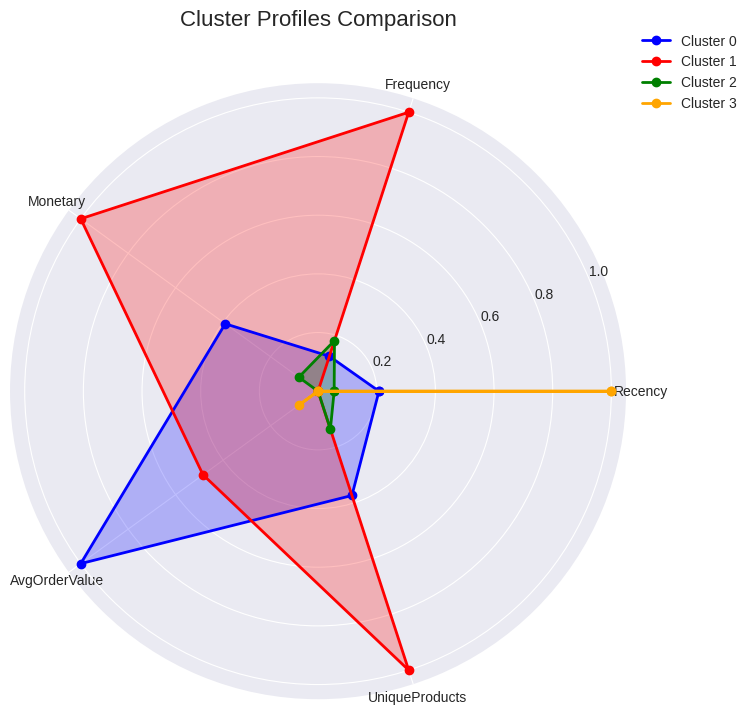

In [15]:
# Calculate cluster profiles
cluster_profiles = rfm_clean.groupby('Cluster')[clustering_features].mean().round(2)
print("Average Values by Cluster:")
print(cluster_profiles)

# Create radar chart for cluster comparison
from math import pi

# Normalize cluster profiles for radar chart
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Set up radar chart
categories = clustering_features
fig = plt.figure(figsize=(12, 8))

# Number of variables
num_vars = len(categories)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the plot
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories)

# Plot each cluster
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for idx, row in cluster_profiles_normalized.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {idx}', color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title('Cluster Profiles Comparison', size=16, y=1.08)
plt.show()

### Create Customer Personas

Based on the cluster characteristics, we'll create business-friendly personas for each segment.

In [4]:
# Define customer personas based on cluster characteristics
def create_persona(cluster_data):
    recency = cluster_data['Recency']
    frequency = cluster_data['Frequency']
    monetary = cluster_data['Monetary']
    avg_order = cluster_data['AvgOrderValue']
    products = cluster_data['UniqueProducts']

    # Create persona based on metrics
    if recency < 50 and frequency > 20 and monetary > 2000:
        return "Champions", "Best customers - Recent, frequent, high spenders"
    elif recency < 100 and frequency > 10 and monetary > 1000:
        return "Loyal Customers", "Regular customers with good spending"
    elif recency > 200 and monetary > 1000:
        return "At Risk", "High-value customers who haven't purchased recently"
    elif frequency < 5 and monetary < 500:
        return "New Customers", "Recently acquired with low engagement"
    else:
        return "Potential Loyalists", "Showing promise, need nurturing"

# Create personas for each cluster
personas = {}
for idx, row in cluster_profiles.iterrows():
    name, description = create_persona(row)
    personas[idx] = {
        'name': name,
        'description': description,
        'size': cluster_sizes[idx],
        'metrics': row.to_dict()
    }

# Display personas
print("CUSTOMER PERSONAS BY CLUSTER\n" + "="*50)
for cluster_id, persona in personas.items():
    print(f"\nCluster {cluster_id}: {persona['name']}")
    print(f"Description: {persona['description']}")
    print(f"Size: {persona['size']} customers")
    print("Key Metrics:")
    for metric, value in persona['metrics'].items():
        print(f"  - {metric}: {value:.2f}")

NameError: name 'cluster_profiles' is not defined

### Alternative Clustering Method: Hierarchical Clustering

**Hierarchical clustering** builds a tree of clusters. Unlike K-Means, it doesn't require specifying the number of clusters beforehand.

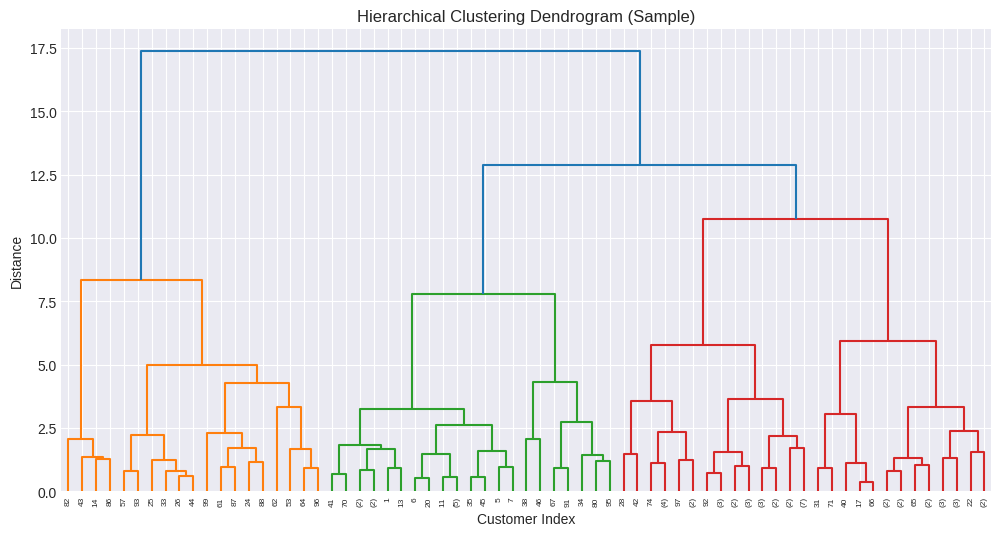


Similarity between K-Means and Hierarchical Clustering: 0.369
(1.0 = identical, 0.0 = random)


In [17]:
# Apply Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix
# Sample data for dendrogram (full dataset would be too large to visualize)
sample_indices = np.random.choice(len(X_scaled), size=min(100, len(X_scaled)), replace=False)
X_sample = X_scaled[sample_indices]

# Perform hierarchical clustering
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=6)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

# Apply Agglomerative Clustering on full dataset
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
agg_clusters = agg_clustering.fit_predict(X_scaled)

# Compare with K-Means
from sklearn.metrics import adjusted_rand_score
similarity = adjusted_rand_score(clusters, agg_clusters)
print(f"\nSimilarity between K-Means and Hierarchical Clustering: {similarity:.3f}")
print("(1.0 = identical, 0.0 = random)")

## 5. Market Basket Analysis with Apriori Algorithm <a id='market-basket'></a>

**Market Basket Analysis** discovers associations between products that are frequently purchased together.

### Key Concepts:
- **Support**: Fraction of transactions containing the itemset
- **Confidence**: Probability of buying Y given that X was bought
- **Lift**: How much more likely Y is purchased when X is purchased

In [18]:
# Prepare data for market basket analysis
# Group products by invoice
basket = df_clean.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert to binary (0/1) matrix
# 1 = product was purchased, 0 = product was not purchased
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

print(f"Transaction matrix shape: {basket_sets.shape}")
print(f"Number of transactions: {basket_sets.shape[0]}")
print(f"Number of unique products: {basket_sets.shape[1]}")

# Show sample transactions
print("\nSample transaction matrix (first 5 transactions, first 5 products):")
basket_sets.iloc[:5, :5]

Transaction matrix shape: (18532, 3877)
Number of transactions: 18532
Number of unique products: 3877

Sample transaction matrix (first 5 transactions, first 5 products):


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK
InvoiceNo,,,,,
536365,0,0,0,0,0
536366,0,0,0,0,0
536367,0,0,0,0,0
536368,0,0,0,0,0
536369,0,0,0,0,0


In [ ]:
# Apply Apriori algorithm
# min_support: Minimum fraction of transactions containing the itemset
min_support = 0.01  # Items appearing in at least 1% of transactions

print(f"Finding frequent itemsets with minimum support of {min_support*100}%...")
frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)

print(f"\nFound {len(frequent_itemsets)} frequent itemsets")
print("\nTop 10 most frequent itemsets:")
frequent_itemsets.sort_values('support', ascending=False).head(10)

Finding frequent itemsets with minimum support of 1.0%...


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# Generate association rules
min_confidence = 0.3  # Rules with at least 30% confidence

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
print(f"Generated {len(rules)} association rules")

# Add additional metrics
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

# Display top rules by lift
print("\nTop 10 Association Rules by Lift:")
top_rules = rules.sort_values('lift', ascending=False).head(10)
for idx, rule in top_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))
    print(f"\nRule {idx}:")
    print(f"  If customer buys: {antecedent}")
    print(f"  Then likely to buy: {consequent}")
    print(f"  Support: {rule['support']:.3f}")
    print(f"  Confidence: {rule['confidence']:.3f}")
    print(f"  Lift: {rule['lift']:.3f}")

### Visualize Association Rules

In [2]:
# Create scatter plot of rules
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rules['support'], rules['confidence'],
                     c=rules['lift'], s=rules['lift']*20,
                     alpha=0.6, cmap='viridis')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (sized and colored by Lift)')
plt.colorbar(scatter, label='Lift')
plt.grid(True, alpha=0.3)
plt.show()

# Filter high-quality rules
high_quality_rules = rules[(rules['lift'] > 2) & (rules['confidence'] > 0.5)]
print(f"\nHigh-quality rules (Lift > 2, Confidence > 50%): {len(high_quality_rules)}")

NameError: name 'plt' is not defined

### Product Recommendation Engine

In [ ]:
def get_recommendations(product, rules_df, max_recommendations=5):
    """
    Get product recommendations based on association rules
    """
    # Find rules where the product is in the antecedent
    relevant_rules = rules_df[rules_df['antecedents'].apply(lambda x: product in x)]

    if len(relevant_rules) == 0:
        return "No recommendations found for this product."

    # Sort by lift and get top recommendations
    relevant_rules = relevant_rules.sort_values('lift', ascending=False).head(max_recommendations)

    recommendations = []
    for idx, rule in relevant_rules.iterrows():
        consequent = ', '.join(list(rule['consequents']))
        recommendations.append({
            'Product': consequent,
            'Confidence': f"{rule['confidence']:.1%}",
            'Lift': f"{rule['lift']:.2f}"
        })

    return pd.DataFrame(recommendations)

# Test the recommendation engine
# Find popular products to test
popular_products = df_clean['Description'].value_counts().head(20).index.tolist()

print("Product Recommendation Engine Demo")
print("=" * 50)
test_product = popular_products[0]
print(f"\nRecommendations for: {test_product}")
print(get_recommendations(test_product, rules))

## 6. Business Insights and Recommendations <a id='insights'></a>

Let's synthesize our findings into actionable business recommendations.

In [1]:
# Combine cluster analysis with purchase patterns
# Add cluster information to original transaction data
df_with_clusters = df_clean.merge(rfm_clean[['CustomerID', 'Cluster']], on='CustomerID')

# Analyze product preferences by cluster
cluster_products = df_with_clusters.groupby(['Cluster', 'Description'])['Quantity'].sum().reset_index()
cluster_products = cluster_products.sort_values(['Cluster', 'Quantity'], ascending=[True, False])

# Top 5 products per cluster
print("TOP 5 PRODUCTS BY CUSTOMER SEGMENT")
print("=" * 50)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} - {personas[cluster]['name']}:")
    top_products = cluster_products[cluster_products['Cluster'] == cluster].head(5)
    for idx, row in top_products.iterrows():
        print(f"  - {row['Description']}: {row['Quantity']} units")

NameError: name 'df_clean' is not defined

In [ ]:
# Generate comprehensive business recommendations
print("\nBUSINESS RECOMMENDATIONS")
print("=" * 70)

for cluster_id, persona in personas.items():
    print(f"\n{persona['name']} (Cluster {cluster_id})")
    print("-" * 50)

    metrics = persona['metrics']

    # Generate specific recommendations based on metrics
    if metrics['Recency'] < 50 and metrics['Frequency'] > 15:
        print("RETAIN: These are your best customers")
        print("  - Offer VIP programs and exclusive early access")
        print("  - Send personalized thank you messages")
        print("  - Provide premium customer service")

    elif metrics['Recency'] > 150 and metrics['Monetary'] > 1000:
        print("RE-ENGAGE: High-value customers at risk of churning")
        print("  - Send win-back campaigns with special offers")
        print("  - Conduct surveys to understand why they left")
        print("  - Offer personalized discounts on previously purchased items")

    elif metrics['Frequency'] < 5:
        print("DEVELOP: New or low-engagement customers")
        print("  - Create onboarding email sequences")
        print("  - Offer first-time buyer discounts")
        print("  - Recommend popular products to build trust")

    else:
        print("GROW: Customers with growth potential")
        print("  - Cross-sell complementary products")
        print("  - Implement loyalty programs")
        print("  - Send targeted product recommendations")

    # ROI Projections
    avg_value = metrics['Monetary'] / metrics['Frequency'] if metrics['Frequency'] > 0 else 0
    potential_revenue = persona['size'] * avg_value * 0.2  # Assume 20% response rate
    print(f"\n  Potential Revenue Impact: ${potential_revenue:,.0f}")

In [ ]:
# Cross-selling opportunities from association rules
print("\n\nCROSS-SELLING OPPORTUNITIES")
print("=" * 70)

# Find the strongest cross-sell opportunities
strong_rules = rules[(rules['lift'] > 3) & (rules['confidence'] > 0.5) & (rules['antecedent_len'] == 1)]
strong_rules = strong_rules.sort_values('lift', ascending=False).head(10)

print("\nTop 10 Cross-Selling Opportunities:")
for idx, (_, rule) in enumerate(strong_rules.iterrows(), 1):
    antecedent = list(rule['antecedents'])[0]
    consequent = list(rule['consequents'])[0]

    print(f"\n{idx}. When customers buy '{antecedent}'")
    print(f"   Recommend '{consequent}'")
    print(f"   Confidence: {rule['confidence']:.1%} | Lift: {rule['lift']:.1f}x")

    # Calculate potential impact
    support_increase = rule['support'] * rule['lift']
    print(f"   Potential sales increase: {support_increase:.2%}")

In [ ]:
# Save results for future use
print("\nSaving analysis results...")

# Save cluster assignments
rfm_clean.to_csv('customer_segments.csv', index=False)
print("Customer segments saved to 'customer_segments.csv'")

# Save association rules
rules.to_csv('association_rules.csv', index=False)
print("Association rules saved to 'association_rules.csv'")

# Save cluster profiles
cluster_profiles.to_csv('cluster_profiles.csv')
print("Cluster profiles saved to 'cluster_profiles.csv'")

print("\nAnalysis complete! Results have been saved for deployment.")